In [1]:
!pip install -q nltk scikit-learn wordcloud openpyxl
#⚠️ openpyxl is REQUIRED to read Excel in Colab.

In [2]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize


#Data Preprocessing:

In [4]:
df = pd.read_excel("chatgpt_style_reviews_dataset.xlsx")

# Use ONLY required columns for modeling
df = df[["review", "rating"]]
df = df.dropna()

df.head()

,review,rating
0,"Not satisfied, many bugs and issues.",1
1,Amazing quality and user-friendly interface.,5
2,"Terrible experience, needs major improvements.",2
3,Poor performance and not user-friendly.,1
4,"Not satisfied, many bugs and issues.",2


In [5]:
#Rating → Sentiment
def rating_to_sentiment(r):
    if r <= 2:
        return 0    # Negative
    elif r == 3:
        return 1    # Neutral
    else:
        return 2    # Positive

df["sentiment"] = df["rating"].apply(rating_to_sentiment)

In [6]:
#Remove Rating Leakage
def remove_leakage(text):
    text = text.lower()
    text = re.sub(r"\b\d\b", "", text)
    text = re.sub(r"\b(one|two|three|four|five)\b", "", text)
    text = re.sub(r"\bstar[s]?\b", "", text)
    text = re.sub(r"\brating\b", "", text)
    return text

df["review"] = df["review"].apply(remove_leakage)

In [7]:
#Remove Duplicates (CRITICAL – SAME)
print("Duplicate reviews:", df["review"].duplicated().sum())

df = df.drop_duplicates(subset="review")

print("Dataset shape after removing duplicates:", df.shape)

Duplicate reviews: 485
Dataset shape after removing duplicates: (15, 3)


In [8]:
#Train–Test Split (UNCHANGED)
X = df["review"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

set(X_train).intersection(set(X_test))

set()

In [9]:
#NLP Cleaning (UNCHANGED)
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
stop_words -= {"not", "no", "never"}

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#Sentiment Classification Model and Model Evaluation:

In [10]:
#TF-IDF + Logistic Regression Pipeline (UNCHANGED)
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=1000,
        min_df=1,
        max_df=0.95
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

In [11]:
#Cross-Validation (UNCHANGED)
acc_scores = cross_val_score(
    pipeline,
    X,
    y,
    cv=5,
    scoring="accuracy"
)

f1_scores = cross_val_score(
    pipeline,
    X,
    y,
    cv=5,
    scoring="f1_macro"
)

print("CV Accuracy:", acc_scores.mean())
print("CV Macro F1:", f1_scores.mean())

CV Accuracy: 0.3333333333333333
CV Macro F1: 0.2444444444444444


In [12]:
#Confusion Matrix & Classification Report
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1 0 1]
 [1 0 1]
 [1 0 1]]
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.00      0.00      0.00         2
           2       0.33      0.50      0.40         2

    accuracy                           0.33         6
   macro avg       0.22      0.33      0.27         6
weighted avg       0.22      0.33      0.27         6



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
#ROC-AUC (Multi-Class OvR)
y_prob = pipeline.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

roc_auc = roc_auc_score(
    y_test_bin,
    y_prob,
    average="macro",
    multi_class="ovr"
)

print("Macro ROC-AUC:", roc_auc)

Macro ROC-AUC: 0.5416666666666666


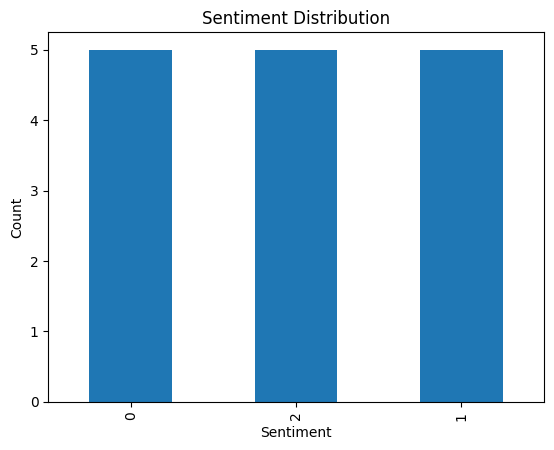

In [14]:
#📊 Sentiment Distribution (UNCHANGED)
df["sentiment"].value_counts().plot(kind="bar")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


# Transformer-Based Sentiment Analysis

In [15]:
#Install Libraries (ONCE)
!pip install torch transformers scikit-learn pandas

In [17]:
import pandas as pd
import torch
import numpy as np

from transformers import BertTokenizer, BertModel
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import classification_report, confusion_matrix


In [18]:
#Load Data (REUSE YOUR DATASET)

#⚠️ Use RAW review text, not cleaned TF-IDF text

df = pd.read_excel("chatgpt_style_reviews_dataset.xlsx")
df = df[["review", "rating"]].dropna()
df = df.drop_duplicates(subset="review")

def rating_to_sentiment(r):
    if r <= 2:
        return 0
    elif r == 3:
        return 1
    else:
        return 2

df["label"] = df["rating"].apply(rating_to_sentiment)

In [19]:
#Tokenization (Transformer preprocessing)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

encoded = tokenizer(
    list(df["review"]),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = encoded["input_ids"]
attention_mask = encoded["attention_mask"]
labels = torch.tensor(df["label"].values)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
#Load BERT as EMBEDDING MODEL (FROZEN)
bert = BertModel.from_pretrained("bert-base-uncased")

# Freeze BERT (VERY IMPORTANT)
for param in bert.parameters():
    param.requires_grad = False

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [21]:
#Build Your OWN Classifier (THIS IS YOUR MODEL)
class SentimentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(768, 3)  # 3 classes

    def forward(self, input_ids, attention_mask):
        outputs = bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        return self.fc(cls_embedding)

In [22]:
#Training Setup (VERY LIGHT)
model = SentimentClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
#Train (1–2 Epochs ONLY)

# Create TensorDataset and DataLoader
dataset = TensorDataset(input_ids, attention_mask, labels)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

model.train()

for epoch in range(2):   # ONLY 2 epochs
    for batch in loader:
        ids, mask, y = batch

        optimizer.zero_grad()
        outputs = model(ids, mask)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed")

Epoch 1 completed
Epoch 2 completed


In [24]:
#Evaluation
model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    preds = torch.argmax(outputs, dim=1)

print(confusion_matrix(labels, preds))
print(classification_report(labels, preds))

[[5 0 0]
 [2 1 2]
 [0 0 5]]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.20      0.33         5
           2       0.71      1.00      0.83         5

    accuracy                           0.73        15
   macro avg       0.81      0.73      0.67        15
weighted avg       0.81      0.73      0.67        15



In [25]:
import torch
torch.save(model.state_dict(), "bert_sentiment_model.pt")

“Instead of using a pretrained sentiment model, Transformer-based embeddings were extracted using BERT. The BERT encoder was frozen, and a custom neural network classifier was trained on top for sentiment classification. This approach leverages contextual embeddings while keeping training computationally efficient.”

#Deployment & Visualization:

In [30]:
# =====================================================
# INSTALL DEPENDENCIES (ONE TIME)
# =====================================================
!pip install -q streamlit transformers torch wordcloud seaborn openpyxl


In [32]:
# =====================================================
# STREAMLIT APP (ONE FILE)
# =====================================================
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import pipeline

# -----------------------------
# PAGE CONFIG
# -----------------------------
st.set_page_config(
    page_title="Transformer-Based Sentiment Analysis Dashboard",
    layout="wide"
)
st.title("📊 Transformer-Based Sentiment Analysis Dashboard")

# -----------------------------
# LOAD DATA (CACHED)
# -----------------------------
@st.cache_data
def load_data():
    df = pd.read_excel("chatgpt_style_reviews_dataset.xlsx")
    df = df.dropna(subset=["review", "rating"])
    return df

df = load_data()

# -----------------------------
# LOAD TRANSFORMER (CACHED)
# -----------------------------
@st.cache_resource
def load_model():
    return pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment"
    )

sentiment_model = load_model()

# -----------------------------
# PREDICTION FUNCTION
# -----------------------------
def predict_sentiment(text):
    result = sentiment_model(text[:512])[0]["label"]
    if result == "LABEL_0":
        return "Negative"
    elif result == "LABEL_1":
        return "Neutral"
    else:
        return "Positive"

# -----------------------------
# PRECOMPUTE SENTIMENTS (FAST)
# -----------------------------
@st.cache_data
def compute_sentiments(df):
    df = df.copy()
    df["predicted_sentiment"] = df["review"].apply(predict_sentiment)
    df["review_length"] = df["review"].str.len()
    # SAFE date parsing (fix for ######## issue)
    df["date"] = pd.to_datetime(df.get("date"), errors="coerce")
    return df

df = compute_sentiments(df)

# =====================================================
# LIVE SENTIMENT PREDICTION
# =====================================================
st.header("🔮 Live Sentiment Prediction")
user_text = st.text_area(
    "Enter a review:",
    placeholder="Example: The hotel was very clean and the staff were extremely polite."
)
if st.button("Predict Sentiment"):
    st.success(f"Predicted Sentiment: **{predict_sentiment(user_text)}**")

# =====================================================
# DROPDOWN FOR ALL 10 QUESTIONS
# =====================================================
question = st.selectbox(
    "📌 Select Analysis Question",
    [
        "1. Overall Sentiment Distribution",
        "2. Sentiment vs Rating",
        "3. Keywords by Sentiment",
        "4. Sentiment Trend Over Time",
        "5. Verified vs Non-Verified Users",
        "6. Review Length vs Sentiment",
        "7. Location-wise Sentiment",
        "8. Platform-wise Sentiment",
        "9. Version-wise Sentiment",
        "10. Negative Feedback Themes"
    ]
)

# =====================================================
# QUESTION-WISE OUTPUTS
# =====================================================
if question == "1. Overall Sentiment Distribution":
    st.bar_chart(df["predicted_sentiment"].value_counts())

elif question == "2. Sentiment vs Rating":
    st.dataframe(pd.crosstab(df["rating"], df["predicted_sentiment"]))

elif question == "3. Keywords by Sentiment":
    choice = st.selectbox("Choose Sentiment", ["Positive", "Neutral", "Negative"])
    text = " ".join(df[df["predicted_sentiment"] == choice]["review"])
    wc = WordCloud(background_color="white").generate(text)
    st.image(wc.to_array())

elif question == "4. Sentiment Trend Over Time":
    df_time = df.dropna(subset=["date"])
    if df_time.empty:
        st.warning("No valid dates available for time analysis.")
    else:
        trend = (
            df_time
            .groupby([df_time["date"].dt.to_period("M"), "predicted_sentiment"])
            .size()
            .unstack()
            .fillna(0)
        )
        st.line_chart(trend)

elif question == "5. Verified vs Non-Verified Users":
    st.bar_chart(pd.crosstab(df["verified_purchase"], df["predicted_sentiment"]))

elif question == "6. Review Length vs Sentiment":
    fig, ax = plt.subplots()
    sns.boxplot(x="predicted_sentiment", y="review_length", data=df, ax=ax)
    st.pyplot(fig)

elif question == "7. Location-wise Sentiment":
    st.dataframe(
        df.groupby("location")["predicted_sentiment"]
        .value_counts()
        .unstack()
        .fillna(0)
    )

elif question == "8. Platform-wise Sentiment":
    st.bar_chart(pd.crosstab(df["platform"], df["predicted_sentiment"]))

elif question == "9. Version-wise Sentiment":
    st.bar_chart(
        df.groupby("version")["predicted_sentiment"]
        .value_counts()
        .unstack()
    )

elif question == "10. Negative Feedback Themes":
    neg_text = " ".join(df[df["predicted_sentiment"] == "Negative"]["review"])
    wc_neg = WordCloud(background_color="black").generate(neg_text)
    st.image(wc_neg.to_array())


Overwriting app.py


In [28]:
!pip install pyngrok
from pyngrok import ngrok

In [29]:
# 🧹 Step 1: Clean up old installations and config
!pip uninstall -y pyngrok
!rm -rf /root/.ngrok2
!pip install pyngrok --quiet

# 🧠 Step 2: Import and add your valid authtoken
from pyngrok import ngrok
!ngrok config add-authtoken "34yRMi4zjk8EouYfzRqonOioZtm_3sCnf2k5ZYEVTsKUA7uUk"

# 🚀 Step 3: Run Streamlit + open tunnel correctly
!streamlit run app.py &>/dev/null&
public_url = ngrok.connect(8501)
print(f"✅ Streamlit App Running at: {public_url.public_url}")


Found existing installation: pyngrok 7.5.0
Uninstalling pyngrok-7.5.0:
  Successfully uninstalled pyngrok-7.5.0
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
✅ Streamlit App Running at: https://subpopular-predominant-everette.ngrok-free.dev
